# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


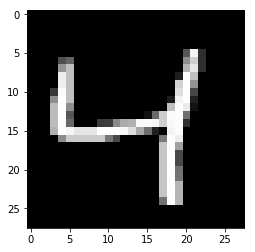

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [4]:
learning_rate = 0.001
print(mnist.train.images.shape)

# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name = 'input')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name = 'targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2, padding='same', name='maxpool1')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2, padding='same', name='maxpool2')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, pool_size=2, strides=2, padding='same', name='encoded')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, size=(7, 7), name='upsample1')
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, size=(14, 14), name='upsample2')
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(images=conv5, size=(28, 28), name='upsample3')
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

(60000, 784)


## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [5]:
sess = tf.Session()

In [6]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})
        if (ii % 20) == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.7031
Epoch: 1/20... Training loss: 0.5691
Epoch: 1/20... Training loss: 0.4753
Epoch: 1/20... Training loss: 0.3281
Epoch: 1/20... Training loss: 0.2357
Epoch: 1/20... Training loss: 0.2109
Epoch: 1/20... Training loss: 0.2038
Epoch: 1/20... Training loss: 0.2032
Epoch: 1/20... Training loss: 0.1886
Epoch: 1/20... Training loss: 0.1663
Epoch: 1/20... Training loss: 0.1629
Epoch: 1/20... Training loss: 0.1620
Epoch: 1/20... Training loss: 0.1560
Epoch: 1/20... Training loss: 0.1551
Epoch: 1/20... Training loss: 0.1494
Epoch: 2/20... Training loss: 0.1514
Epoch: 2/20... Training loss: 0.1491
Epoch: 2/20... Training loss: 0.1453
Epoch: 2/20... Training loss: 0.1395
Epoch: 2/20... Training loss: 0.1426
Epoch: 2/20... Training loss: 0.1415
Epoch: 2/20... Training loss: 0.1375
Epoch: 2/20... Training loss: 0.1355
Epoch: 2/20... Training loss: 0.1367
Epoch: 2/20... Training loss: 0.1322
Epoch: 2/20... Training loss: 0.1326
Epoch: 2/20... Training loss: 0.1312
E

Epoch: 15/20... Training loss: 0.0957
Epoch: 15/20... Training loss: 0.0965
Epoch: 15/20... Training loss: 0.0932
Epoch: 15/20... Training loss: 0.0930
Epoch: 15/20... Training loss: 0.0916
Epoch: 16/20... Training loss: 0.0957
Epoch: 16/20... Training loss: 0.0946
Epoch: 16/20... Training loss: 0.0954
Epoch: 16/20... Training loss: 0.0916
Epoch: 16/20... Training loss: 0.0921
Epoch: 16/20... Training loss: 0.0989
Epoch: 16/20... Training loss: 0.0940
Epoch: 16/20... Training loss: 0.0965
Epoch: 16/20... Training loss: 0.0910
Epoch: 16/20... Training loss: 0.0955
Epoch: 16/20... Training loss: 0.0951
Epoch: 16/20... Training loss: 0.0974
Epoch: 16/20... Training loss: 0.0905
Epoch: 16/20... Training loss: 0.0939
Epoch: 16/20... Training loss: 0.0933
Epoch: 17/20... Training loss: 0.0935
Epoch: 17/20... Training loss: 0.0941
Epoch: 17/20... Training loss: 0.0938
Epoch: 17/20... Training loss: 0.0923
Epoch: 17/20... Training loss: 0.0956
Epoch: 17/20... Training loss: 0.0924
Epoch: 17/20

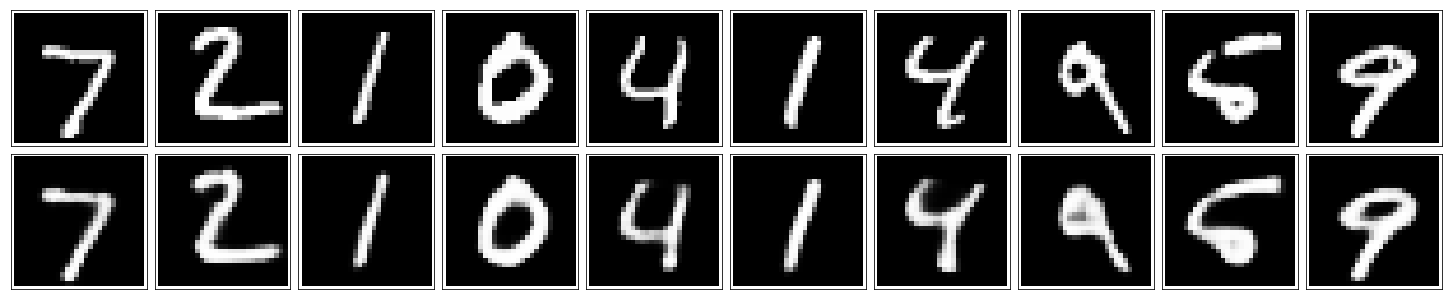

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [8]:
sess.close()

### Results and Observations

The first time I used 2 x 2 convolutions and this resulted in really bad performance. The reconstructed images were hardly recognizable. The training got stuck after a few epochs and could not improve anymore.

Another interesting problem was, that I gave the convolutional layers a name, but that inhibited that I could run the code again to change some settings, so I removed the `name=` part.

When using 3 x 3 convolutions, the network performed as expected.



## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [9]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2, padding='same', name='maxpool1') 
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2, padding='same', name='maxpool2')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, pool_size=2, strides=2, padding='same', name='encoded')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, size=(7, 7), name='upsample1')
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, size=(14, 14), name='upsample2')
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(images=conv5, size=(28, 28), name='upsample3')
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [10]:
sess = tf.Session()

In [11]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})
        if (ii % 50) == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.7136
Epoch: 1/100... Training loss: 0.2629
Epoch: 1/100... Training loss: 0.2288
Epoch: 1/100... Training loss: 0.2033
Epoch: 1/100... Training loss: 0.1920
Epoch: 1/100... Training loss: 0.1746
Epoch: 2/100... Training loss: 0.1722
Epoch: 2/100... Training loss: 0.1655
Epoch: 2/100... Training loss: 0.1671
Epoch: 2/100... Training loss: 0.1600
Epoch: 2/100... Training loss: 0.1589
Epoch: 2/100... Training loss: 0.1497
Epoch: 3/100... Training loss: 0.1499
Epoch: 3/100... Training loss: 0.1409
Epoch: 3/100... Training loss: 0.1418
Epoch: 3/100... Training loss: 0.1376
Epoch: 3/100... Training loss: 0.1448
Epoch: 3/100... Training loss: 0.1393
Epoch: 4/100... Training loss: 0.1377
Epoch: 4/100... Training loss: 0.1350
Epoch: 4/100... Training loss: 0.1325
Epoch: 4/100... Training loss: 0.1360
Epoch: 4/100... Training loss: 0.1306
Epoch: 4/100... Training loss: 0.1284
Epoch: 5/100... Training loss: 0.1301
Epoch: 5/100... Training loss: 0.1328
Epoch: 5/100

Epoch: 36/100... Training loss: 0.1057
Epoch: 36/100... Training loss: 0.1032
Epoch: 36/100... Training loss: 0.1055
Epoch: 36/100... Training loss: 0.1043
Epoch: 37/100... Training loss: 0.1015
Epoch: 37/100... Training loss: 0.1071
Epoch: 37/100... Training loss: 0.1061
Epoch: 37/100... Training loss: 0.1059
Epoch: 37/100... Training loss: 0.1067
Epoch: 37/100... Training loss: 0.1058
Epoch: 38/100... Training loss: 0.1036
Epoch: 38/100... Training loss: 0.1038
Epoch: 38/100... Training loss: 0.1031
Epoch: 38/100... Training loss: 0.1055
Epoch: 38/100... Training loss: 0.1027
Epoch: 38/100... Training loss: 0.1051
Epoch: 39/100... Training loss: 0.1065
Epoch: 39/100... Training loss: 0.1057
Epoch: 39/100... Training loss: 0.1033
Epoch: 39/100... Training loss: 0.1016
Epoch: 39/100... Training loss: 0.1057
Epoch: 39/100... Training loss: 0.1040
Epoch: 40/100... Training loss: 0.1047
Epoch: 40/100... Training loss: 0.1039
Epoch: 40/100... Training loss: 0.1055
Epoch: 40/100... Training

Epoch: 71/100... Training loss: 0.0991
Epoch: 71/100... Training loss: 0.1003
Epoch: 71/100... Training loss: 0.0998
Epoch: 72/100... Training loss: 0.1031
Epoch: 72/100... Training loss: 0.1008
Epoch: 72/100... Training loss: 0.1001
Epoch: 72/100... Training loss: 0.1022
Epoch: 72/100... Training loss: 0.0992
Epoch: 72/100... Training loss: 0.1004
Epoch: 73/100... Training loss: 0.1006
Epoch: 73/100... Training loss: 0.1013
Epoch: 73/100... Training loss: 0.1014
Epoch: 73/100... Training loss: 0.1004
Epoch: 73/100... Training loss: 0.0994
Epoch: 73/100... Training loss: 0.0982
Epoch: 74/100... Training loss: 0.1009
Epoch: 74/100... Training loss: 0.0971
Epoch: 74/100... Training loss: 0.0998
Epoch: 74/100... Training loss: 0.1006
Epoch: 74/100... Training loss: 0.1024
Epoch: 74/100... Training loss: 0.1017
Epoch: 75/100... Training loss: 0.1044
Epoch: 75/100... Training loss: 0.1021
Epoch: 75/100... Training loss: 0.0974
Epoch: 75/100... Training loss: 0.0970
Epoch: 75/100... Training

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

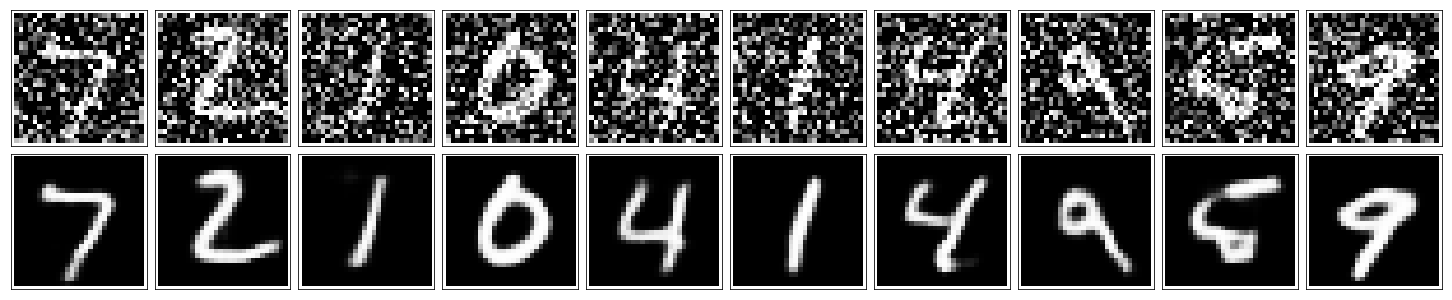

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)